In [1]:
from abc import ABC,abstractmethod
import json
from datetime import datetime, timedelta
import sys
from random import randint
import numpy as np
from numpy.random import exponential

In [2]:
class typeGenerator(ABC):
    def __init__(self):
        pass

    @abstractmethod
    def generateEl(self,**args):
        pass

    def addDict(self,d,keyName,**args):
        d[keyName] = self.generateEl(**args)
        return d

class intGenerator(typeGenerator):
    def __init__(self):
        return super().__init__()

    def generateEl(self,*argList,**args):
        if argList:
            args = argList[0]
        min = args.get("min",0)
        max = args.get("max",1000)
        return randint(min, max)

class idGenerator(typeGenerator):
    def __init__(self):
        return super().__init__()

    def generateEl(self,*argList,**args):
        if argList:
            args = argList[0]
        prefix = args.get("prefix","id")
        min = args.get("min",0)
        max = args.get("max",1000)
        return prefix+"_"+str(randint(min, max)).zfill(len(str(max))+1)

    def addDict(self, d,keyName="id", **args):
        return super().addDict(d, keyName,**args)

class dateGenerator(typeGenerator):
    def __init__(self):
        return super().__init__()

    def generateEl(self,*argList,**args):
        if argList:
            args = argList[0]
        startDate = args.get("startDate",datetime(2010,1,1))
        endDate = args.get("endDate",datetime.now())
        minPaceSeconds = args.get("minPaceSeconds",3600)
        maxPaceSeconds = args.get("maxPaceSeconds",datetime.now())
        maxS = int((endDate-startDate).total_seconds())
        return startDate+timedelta(0,randint(minPaceSeconds,maxS))

    def addDict(self, d, keyName="ts", **args):
        return super().addDict(d, keyName,**args)

class tickGenerator(typeGenerator):
    def __init__(self):
        self.lastTick = False
        return super().__init__()

    def generateEl(self,*argList,**args):
        if argList:
            args = argList[0]
        if not self.lastTick:
            self.lastTick = args.get("firstTick",datetime(2010,1,1))
        minTick = args.get("minTick",1)
        maxTick = args.get("maxTick",10)
        self.lastTick += timedelta(0,randint(1,maxTick))
        return self.lastTick

In [40]:
class expIntGenerator(typeGenerator):
    def __init__(self):
        return super().__init__()

    def generateEl(self,*argList,**args):
        if argList:
            args = argList[0]
        scale = args.get("scale",1)
        multiplier = args.get("multiplier",500)
        return round(exponential(scale) * multiplier)

In [46]:
class expFloatGenerator(typeGenerator):
    def __init__(self):
        return super().__init__()

    def generateEl(self,*argList,**args):
        if argList:
            args = argList[0]
        scale = args.get("scale",1)
        multiplier = args.get("multiplier",500)
        return (exponential(scale) * multiplier)

In [52]:
import matplotlib.pyplot as plt

In [71]:
x = expIntGenerator()

to_plot = ([(x.generateEl()) for _ in range(10000)])

(array([6.879e+03, 2.189e+03, 6.520e+02, 1.910e+02, 6.900e+01, 1.500e+01,
        3.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([   0. ,  581.7, 1163.4, 1745.1, 2326.8, 2908.5, 3490.2, 4071.9,
        4653.6, 5235.3, 5817. ]),
 <a list of 10 Patch objects>)

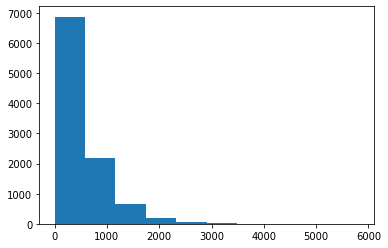

In [72]:
plt.hist(to_plot)

In [73]:
x = expFloatGenerator()

to_plot = ([(x.generateEl()) for _ in range(10000)])

(array([6.645e+03, 2.252e+03, 7.490e+02, 2.320e+02, 8.800e+01, 1.900e+01,
        1.200e+01, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([1.06983191e-03, 5.53045088e+02, 1.10608911e+03, 1.65913312e+03,
        2.21217714e+03, 2.76522116e+03, 3.31826518e+03, 3.87130919e+03,
        4.42435321e+03, 4.97739723e+03, 5.53044125e+03]),
 <a list of 10 Patch objects>)

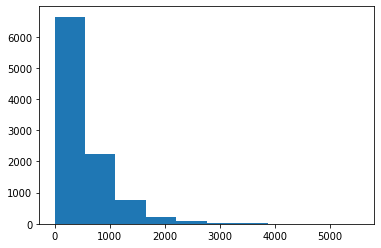

In [74]:
plt.hist(to_plot)

In [140]:
class nonUniformeIdGenerator(typeGenerator):
    def __init__(self):
        return super().__init__()

    def generateEl(self,*argList,**args):
        if argList:
            args = argList[0]
        prefix = args.get("prefix","id")
        lam = args.get("lam",1)
        multiplier = args.get("multiplier",1)
        #return prefix+"_"+str(np.random.poisson(lam=1.0)*multiplier).zfill(len(str(max))+1)
        return round(np.random.poisson(lam)*multiplier)


    def addDict(self, d,keyName="id", **args):
        return super().addDict(d, keyName,**args)

In [155]:
x = nonUniformeIdGenerator()

to_plot = ([(x.generateEl(lam=10)) for _ in range(10000)])

(array([  31.,  260., 1994., 2392., 2374., 2092.,  584.,  235.,   31.,
           7.]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <a list of 10 Patch objects>)

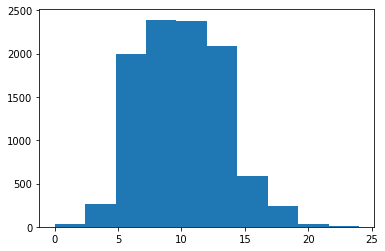

In [156]:
plt.hist(to_plot)